In [46]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
from tqdm import tqdm
import util
import viz
PROCESSED_DIR = 'processed'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading

**load gt latents**

In [47]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

**load annotations in different directions**

In [48]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
N = len(attrs)

**orthogonalize**

In [49]:
vecs = [pkl.load(open(oj(PROCESSED_DIR, f'03_m_{attr}.pkl'), 'rb')).coef_.flatten()
        for attr in attrs]
# vecs_orth = {}
vecs_orth = util.orthogonalize_paper(np.array(vecs).transpose())

# also put them into a dict
vecs_orth_dict = {
    attr: vecs_orth[:, i] for i, attr in enumerate(attrs)
}

vecs_orig_arr = np.array(vecs)
vecs_orth_arr = vecs_orth.transpose() # np.array([vecs_orth[k] for k in vecs_orth])
sims_orig = sklearn.metrics.pairwise.cosine_similarity(vecs_orig_arr)
sims_orth = sklearn.metrics.pairwise.cosine_similarity(vecs_orth_arr)

0.46675862005139135
1.196959198423997e-16


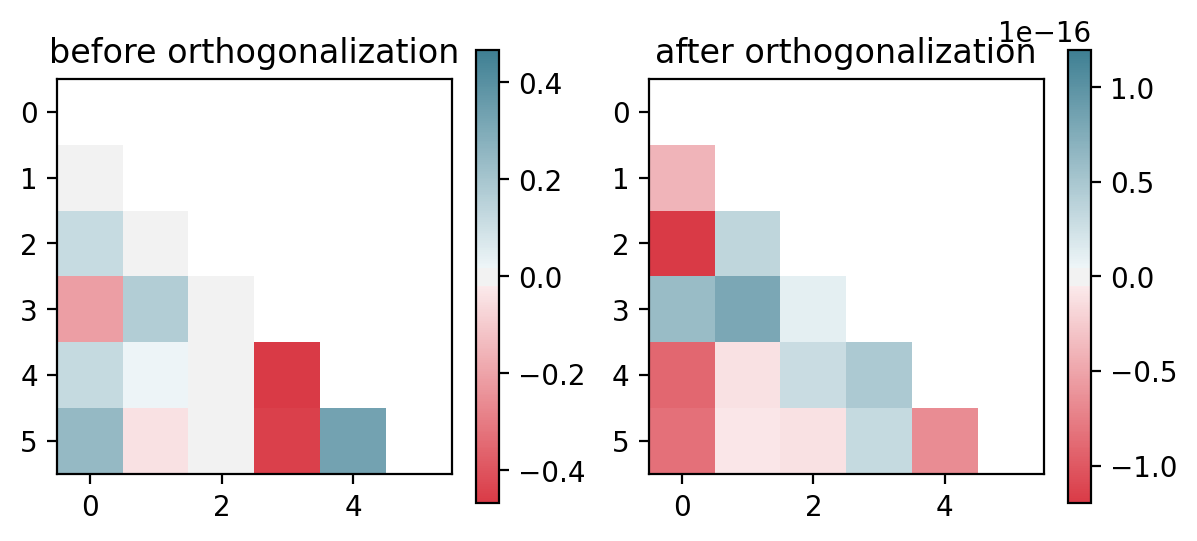

In [50]:
mask = np.triu(np.ones_like(sims_orig, dtype=np.bool))
plt.figure(dpi=200, figsize=(7, 3))
plt.subplot(121)
plt.title('before orthogonalization')
viz.corrplot(sims_orig)
plt.colorbar()

plt.subplot(122)
plt.title('after orthogonalization')
viz.corrplot(sims_orth)
plt.colorbar()
plt.show()

# fitting better linear models

6it [00:01,  4.15it/s]


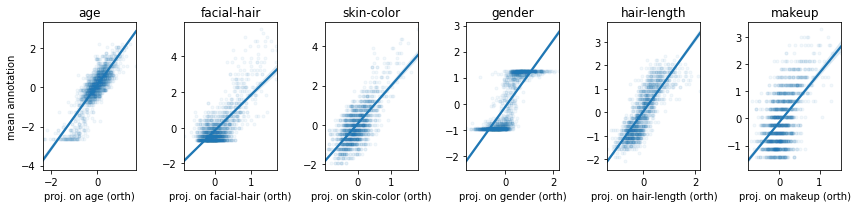

In [51]:
X = latents
R = 1
C = N
plt.figure(figsize=(C * 2, 3))
for i, attr in tqdm(enumerate(attrs)):
    attr_to_proj = attr
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
    direction = vecs_orth_dict[attr]
    projections = X_test @ direction # m.predict(X_test)
    
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    sns.regplot(projections, y_test, marker='.', scatter_kws={'alpha': 0.05})
    
    if i == 0:
        plt.ylabel('mean annotation')
    plt.xlabel(f'proj. on {attr_to_proj} (orth)')
#     plt.xlabel('projection onto linear direction')
#     plt.plot(projections, mean_attr, '.')
plt.tight_layout()

**how independent are they**

In [ ]:
R, C = N, N
N = len(attrs)
corr_mat = np.zeros((N, N))
i = 0
plt.figure(figsize=(12, 12), dpi=150)
for r in tqdm(range(N)):
    attr = attrs[r]
    # m = sklearn.linear_model.RidgeCV()
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
#     m = pkl.load(open(oj(PROCESSED_DIR, f'02_m_{attr}.pkl'), 'rb'))
    # m.fit(X_train, y_train)
    direction = vecs_orth_dict[attr]
#     projections = X_test @ direction # m.predict(X_test)
    
    for c in range(N):
        attr_test = attrs[c]
        projections = X_test @ direction
        y = annotations_dict[attr_test].mean(axis=1)
        y = (y - y.mean()) / (y.std())
        y_train, y_test = sklearn.model_selection.train_test_split(
            y, test_size=0.3, random_state=42)  
        

        plt.subplot(R, C, i + 1)
#         if r == 0:
#             plt.title('measure ' + attr_test)
        if c == 0:
            plt.ylabel('proj. on' + attr)
        
        sns.regplot(projections, y_test, marker='.', scatter_kws={'alpha': 0.05})
        corr_mat[r, c] = np.corrcoef(projections, y_test)[0, 1]
        plt.yticks([])
        if r == N - 1:
            plt.xlabel(f'measure {attr_test}')
        i += 1
plt.tight_layout() 

100%|██████████| 6/6 [00:08<00:00,  1.44s/it]


In [ ]:
plt.figure(dpi=300)
viz.corrplot(corr_mat)
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()